In [20]:
import os, json
import pandas as pd
from pathlib import Path 

# Paper Summary

## Types of Features

1. Lexical features: word or character-based statistical measures of lexical variation.
     -  Sentence/line length [Yule 1938; Argamon et al. 2003]
     -  Vocabulary richness [Yule 1944]
     -  Word-length distributions [De Vel et al. 2001; Zheng et al. 2006]

2.  Syntactic features
    -  function words [Mosteller and Wallace 1964]
        -   Shown to be highly effective discriminators of authorship, since the usage variations of such words are a strong reflection of stylistic choices [Koppel et al. 2006]
    -  punctuation [Baayen et al. 2002]
    -  part-of-speech tag n-grams [Baayen et al. 1996; Argamon et al. 1998]

3.  Structural features - especially useful for online text
    -  attributes relating to text organization and layout [De Vel et al. 2001; Zheng et al. 2006]
    -  technical features such as the use of various file extensions, fonts, sizes, and colors [Abbasi and Chen 2005]
    -  When analyzing computer programs, different structural features (e.g., the use of braces and comments) are utilized [Oman and Cook 1989].

4.  Content-specific features are comprised of important keywords and phrases on certain topics [Martindale and McKenzie 1995]
    -  word n-grams [Diederich et al. 2003]. 
        -  For example, content-specific features on a discussion of computers may include “laptop” and “notebook.”

5.  Idiosyncratic features 
    -  misspellings
    -  grammatical mistakes
    -  other usage anomalies. 
    -  Such features are extracted using spelling and grammar checking tools and dictionaries [Chaski 2001; Koppel and Schler 2003]
    -   May also reflect deliberate author choices or cultural differences, such as use of the word “center” versus “center” [Koppel and Schler 2003].
    
The use of feature sets containing lexical, syntactic, structural, and syntactic features has been shown more effective for online identification than feature sets containing only a subset of these feature groups [Abbasi and Chen 2005; Zheng et al. 2006].

## Techniques

### Supervised techniques 

1. support vector machines (SVMs) [Diederich 2000; De Vel 2001; Li et al. 2006]
    - highly robust technique that has provided powerful categorization capabilities for online authorship analysis.
    - In head-to-head comparisons, SVM significantly outperformed other supervised learning methods such as neural networks and decision trees [Abbasi and Chen 2005; Zheng et al. 2006].
2. neural networks [Merriam 1995; Tweedie et al. 1996; Zheng et al. 2006]
3. decision trees [Apte 1998; Abbasi and Chen 2005]
4. linear discriminant analysis [Baayen 2002; Chaski 2005]

### Unsupervised stylometric categorization techniques 
1. cluster analysis [Holmes 1992]
2. principal component analysis (PCA) [Burrows 1987, Baayen et al. 1996]
    - Ability to capture essential variance across large numbers of features in a reduced dimensionality makes it attractive for text analysis problems, which typically involve large feature sets
    - Also been shown effective for online stylometric analysis [Abbasi and Chen 2006]

Supervised techniques are those that require author-class labels for categorization, while unsupervised techniques make categorizations with no prior knowledge of author classes. __Kaede note:__ Can we can use unsupervised techniques for similarity detection to merge duplicate accounts?

## Miscellaneous

__Kaede note:__ We are studying what the paper calls "Asynchronous CMC" and labels "D1". We are tackling the message-level identification task.

Message-level analysis is not highly scalable to larger numbers of authors in cyberspace due to difficulties in consistently identifying texts shorter than 250 words [Forsyth and Holmes 1996]
__Kaede note:__ In her email, Dr. Overdorf says we should "not be afraid of combining or grouping comments together to deal with the fact that some of them are quite short. Just be clever about it and make sure you don’t split any single comment up." 

Example of stylometry focusing on "feedback comments" is [Hayne and Rice 1997; Hayne et al. 2003]. Feature sets used in previous online studies typically consist of a handful of categories and less than 500 features. Two types of feature sets have been used in previous research: author-group level and individual-author level

__Kaede note:__ 2.3.1 Individual-Level Techniques; Struggled to understand this section and determine if it was relevant to us

## Main Paper Technique: Writeprints

Writeprints is a Karhunen-Loeve-transforms-based technique that uses a sliding window and pattern disruption to capture feature usage variance at a finer level of granularity. The use of individual-author-level feature sets is intended to provide greater scalability as compared to traditional machine learning techniques that only utilize a single author-group-level set (e.g., SVM, PCA).

### System Design

#### 5.1 Feature Extraction
1. All message signatures are initially filtered out in order to remove obvious identifiers [De Vel et al. 2001]
2. Two feature sets:
    1. a baseline feature set (BF) consisting of static author-group-level features
        - "fairly straightforward extraction procedure"
    2. an extended feature set (EF) consisting of static and dynamic features.
    

    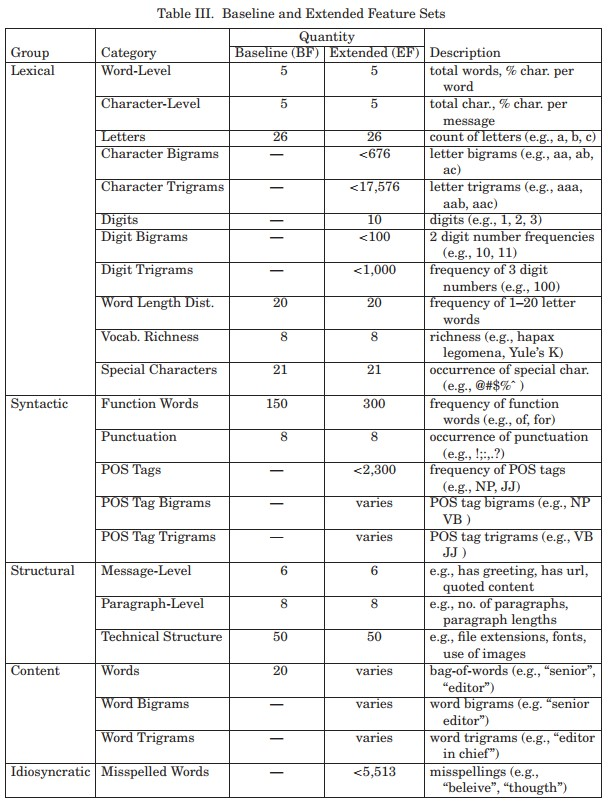

# Data Pre-Processing
## Aggregate data, push to csv, create subset for pilot model development

In [21]:
# this finds our json files
path_to_json = 'user_comments/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# here I define my pandas Dataframe with the columns I want to get from the json
#jsons_data = pd.DataFrame(columns=['author', 'body', 'created_utc', 'edited', 'id', 'is_submitter', 'link_id', 'parent_id', 'score', 'subreddit', 'subreddit_id'])
print(len(json_files))
df = pd.DataFrame()
for i in range(len(json_files)):
    if (i != 532) & (i != 991):
        with open(os.path.join(path_to_json, json_files[i])) as fp:
            data = json.loads(fp.read())
            tmp = pd.DataFrame.from_dict(data)
            df = pd.concat([df, tmp])
    if (i == 532) | (i == 991):
        print("Corrupted: File #" + str(i) + ", " + json_files[i])

filepath = Path('cmts_agg.csv')    
df.to_csv('cmts_agg.csv')
(df.groupby(['author']).size()).to_frame(name = "cmts_freq").to_csv('author_freqs.csv')
df = df.sample(n=10000)
df.to_csv('cmts_sample.csv')

1535
Corrupted: File #532, an_average_potato_1.json
Corrupted: File #991, jlba64.json


## Read in Data to run model

In [6]:
user_levels = pd.read_csv('user_levels.csv')
cmts = pd.read_csv('cmts_sample.csv')
cmts = cmts[['author', 'body']].rename(columns={"body": "text"})
cmts = cmts[0:100]

In [5]:
### https://towardsdatascience.com/structured-natural-language-processing-with-pandas-and-spacy-7089e66d2b10

## Loading comments into spaCy 'doc' objects
# pip install spacy
import spacy
# RUN THIS IN A TERMINAL: 
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
docs = list(nlp.pipe(cmts.body))

In [6]:
# https://levelup.gitconnected.com/text-cleansing-in-nlp-tasks-594b93d648d6

# Remove non-english?
# Remove certain characters?
# Remove stop words?

# Doing preprocessing separately within each feature generation for now

# Calculating Features

In [99]:
# So we don't have to reload cmts each time, we will modify a version of base json data called cmts_aug
cmts_aug = cmts

## Lexical: Letter Counts

In [100]:
import re
from collections import Counter
import numpy as np

# cmts_copy = target augmentation dataframe
letter_counts = pd.DataFrame()
lower_alphabet_docs = [re.sub(r'[^a-z]', '', i.text.lower()) for i in docs]
for i in lower_alphabet_docs:
    tmp = pd.DataFrame.from_dict(Counter(i), orient = 'index').transpose()
    if tmp.empty:
        tmp = pd.DataFrame({'a': np.NaN}, index = [0])
    letter_counts = pd.concat([letter_counts, tmp])
letter_counts = letter_counts.reindex(sorted(letter_counts.columns), axis=1).reset_index(drop=True).add_prefix('let_cnt_')
cmts_aug = pd.merge(cmts_aug, letter_counts, left_index=True, right_index=True)

## Lexical: World Length Dist. (frequency of 1-20 letter words)

In [101]:
# More preprocessing needed here... punctuation, contractions...

# cmts_copy = target augmentation dataframe
len_tokenized_docs = [[len(i.lemma_) for i in doc if not i.is_punct ] for doc in docs]
word_length_counts = pd.DataFrame()
for i in len_tokenized_docs:
    tmp = pd.DataFrame.from_dict(Counter(i), orient = 'index')
    if tmp.empty:
        tmp = pd.DataFrame({'0': np.NaN}, index = [1])
    tmp = tmp[tmp.index.isin(range(1,20))] # This line ensures we only calculate frequency of words up to 20 characters in length
    word_length_counts = pd.concat([word_length_counts, tmp.transpose()])
word_length_counts = word_length_counts.reindex(sorted(word_length_counts.columns), axis=1).reset_index(drop=True).add_prefix('wrdlen_cnt_')
cmts_aug = pd.merge(cmts_aug, word_length_counts, left_index=True, right_index=True)

## Syntactic: Function Words (frequency of function words [e.g. of, for])

In [102]:
# I think closest to 'function words' in SpaCy is stop words

from itertools import compress
isstop_tokenized_docs = [[i.is_stop for i in doc if not i.is_punct ] for doc in docs]
tokenized_docs = [[i.text.lower() for i in doc if not i.is_punct ] for doc in docs]
stop_word_counts = pd.DataFrame()
for i in range(len(docs)):
    tmp = list(compress(tokenized_docs[i], isstop_tokenized_docs[i]))
    tmp = Counter(tmp)
    tmp = pd.DataFrame.from_dict(Counter(tmp), orient = 'index').transpose()
    if tmp.empty:
        tmp = pd.DataFrame({'I': np.NaN}, index = [0])    
    stop_word_counts = pd.concat([stop_word_counts, tmp])

# Keep top 150 overall as paper does (how are words sorted if same count?)
stop_word_top150 = list(stop_word_counts.sum(axis = 0).sort_values(ascending=False)[0:150].keys())
stop_word_counts = stop_word_counts[stop_word_top150]

stop_word_counts = stop_word_counts.reindex(sorted(stop_word_counts.columns), axis = 1).reset_index(drop=True).add_prefix('stpwrd_cnt_')
cmts_aug = pd.merge(cmts_aug, stop_word_counts, left_index=True, right_index=True) 

## Just discovered writeprints package..

In [9]:
# pip install writeprints
from writeprints.text_processor import Processor
processor = Processor (flatten = False) # Flatten will split vectorized featurs into individual featurs

In [7]:
features = processor.extract_df(cmts)

  0%|          | 0/100 [00:00<?, ?it/s]

# Classify Authors